# Stage 2: Poduct Classification with ResNet-18
**Grocery Store Dataset - Fine-Grained Product Recognition**

---

## 1. Overview

**Objective:** Train ResNet-18 to classify 81 grocery product categories

**Dataset:** Grocery Store Dataset (Klasson et al., 2019)
- 2640 train / 2485 test images (natural shelf photos)
- 81 fine-grained product classes
- Real-world conditions: varied lighting, occlusion, clutter

**Approach:**
- ResNet-18 pretrained on ImageNet
- Fine-tune on grocery products
- Cross-entropy loss, SGD optimizer

**Target:** 80%+ test accuracy

**References:**
- Paper: [Klasson et al., 2019](https://doi.org/10.1109/WACV.2019.00058)
- Dataset: [GitHub](https://github.com/marcusklasson/GroceryStoreDataset), [Kaggle](https://www.kaggle.com/datasets/validmodel/grocery-store-dataset/data)
- Model: [He et al., 2016](https://doi.org/10.1109/CVPR.2016.90)

## 2. Environment Setup & Dependencies

In [ ]:
# Install wandb (if needed)
!pip install wandb -q

# Install required packages (if needed)
#!pip install torch torchvision matplotlib pandas seaborn scikit-learn tqdm

# Imports
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader
from torchvision import transforms, models
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.metrics import classification_report, f1_score
from tqdm import tqdm
import wandb
import os

# Reproducibility
torch.manual_seed(42)
np.random.seed(42)
if torch.cuda.is_available():
    torch.cuda.manual_seed_all(42)

# Device
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(f"Using device: {device}")

Using device: cpu


In [ ]:
# Then connect to your WandB account
from google.colab import userdata

def wandb_connect():
    wandb_api_key_label = "wandb_api_key"
    wandb_api_key = userdata.get('WANDB_API_KEY') # here use your API key from WandB interface

    wandb_conx = wandb.login(key = wandb_api_key)
    print(f"Connected to Wandb online interface : {wandb_conx}")

wandb_connect()

## 3. Dataset Download & Verification


In [4]:
import kagglehub
import os
from pathlib import Path

# Download dataset
path = kagglehub.dataset_download("validmodel/grocery-store-dataset")
dataset_root = os.path.join(path, "GroceryStoreDataset", "dataset")
train_path = os.path.join(dataset_root, "train")
test_path = os.path.join(dataset_root, "test")

def find_leaf_classes(root_path):
    """Find all directories that contain images (leaf nodes)"""
    leaf_dirs = []
    for dirpath, dirnames, filenames in os.walk(root_path):
        # If directory has image files and no subdirectories with images, it's a leaf
        has_images = any(f.lower().endswith(('.jpg', '.jpeg', '.png')) for f in filenames)
        if has_images:
            # Get relative path from root as class name
            class_name = os.path.relpath(dirpath, root_path)
            leaf_dirs.append(class_name)
    return sorted(leaf_dirs)

# Find all leaf classes
train_classes = find_leaf_classes(train_path)
test_classes = find_leaf_classes(test_path)

print(f"Train classes: {len(train_classes)}")
print(f"Test classes: {len(test_classes)}")

# Count images per class
train_count = sum(len([f for f in os.listdir(os.path.join(train_path, c))
                       if f.endswith('.jpg')]) for c in train_classes)
test_count = sum(len([f for f in os.listdir(os.path.join(test_path, c))
                      if f.endswith('.jpg')]) for c in test_classes)

print(f"\nTrain images: {train_count}")
print(f"Test images: {test_count}")

print(f"\nFirst 5 classes:\n{train_classes[:5]}")
print(f"\nLast 5 classes:\n{train_classes[-5:]}")

# Note: We ignore the validation set (added post-publication, not used in original paper)

100%|██████████| 118M/118M [00:06<00:00, 17.7MB/s]

Extracting files...


Train classes: 81
Test classes: 81

Train images: 2640
Test images: 2485

First 5 classes:
['Fruit/Apple/Golden-Delicious', 'Fruit/Apple/Granny-Smith', 'Fruit/Apple/Pink-Lady', 'Fruit/Apple/Red-Delicious', 'Fruit/Apple/Royal-Gala']

Last 5 classes:
['Vegetables/Red-Beet', 'Vegetables/Tomato/Beef-Tomato', 'Vegetables/Tomato/Regular-Tomato', 'Vegetables/Tomato/Vine-Tomato', 'Vegetables/Zucchini']


In [5]:
# Add to sidebar (optional UX practice - for easier browsing)
from google.colab import drive
!ln -s {dataset_root} /content/dataset

print("dataset ready to use in sidebar")

dataset ready to use in sidebar


## 4. Data Exploration
- Class distribution
- Sample images visualization
- Dataset statistics

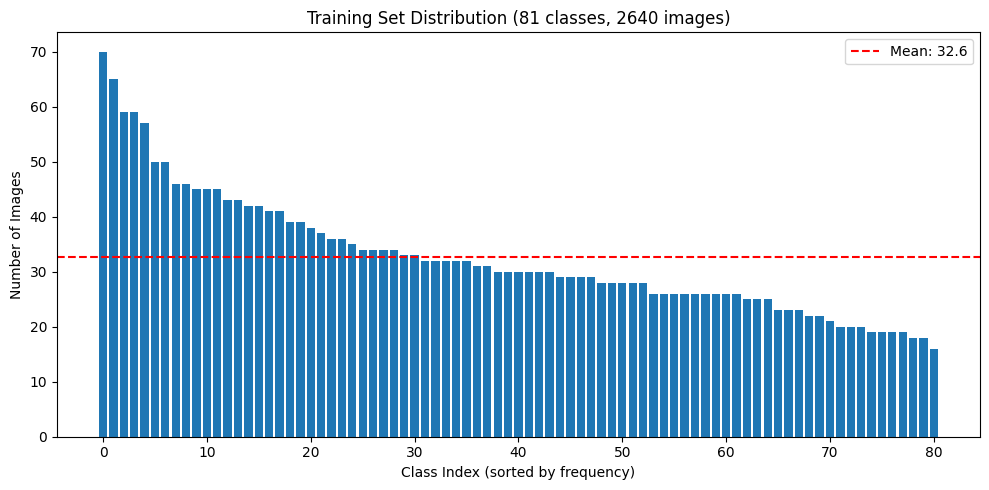


Top 5 classes: [('Fruit/Satsumas', 70), ('Fruit/Apple/Royal-Gala', 65), ('Fruit/Apple/Granny-Smith', 59), ('Fruit/Apple/Pink-Lady', 59), ('Fruit/Orange', 57)]
Bottom 5 classes: [('Vegetables/Cabbage', 19), ('Vegetables/Ginger', 19), ('Vegetables/Potato/Floury-Potato', 18), ('Vegetables/Red-Beet', 18), ('Vegetables/Asparagus', 16)]



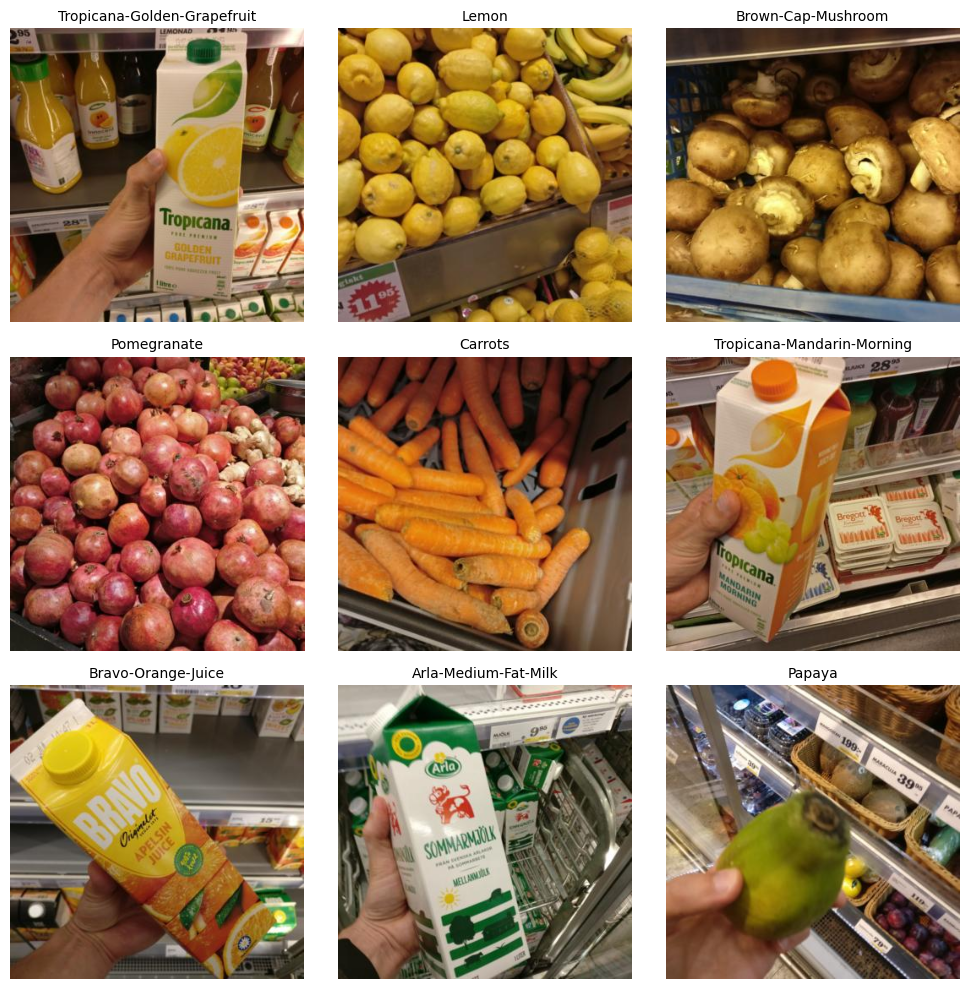


Sample image size: (348, 348)
Color mode: RGB


In [6]:
from PIL import Image
import random

# 1. Class distribution
train_img_counts = [(c, len([f for f in os.listdir(os.path.join(train_path, c))
                              if f.endswith('.jpg')]))
                    for c in train_classes]
train_img_counts.sort(key=lambda x: x[1], reverse=True)

# Plot distribution
plt.figure(figsize=(10, 5))
classes, counts = zip(*train_img_counts)
plt.bar(range(len(classes)), counts)
plt.xlabel('Class Index (sorted by frequency)')
plt.ylabel('Number of Images')
plt.title(f'Training Set Distribution ({len(train_classes)} classes, {sum(counts)} images)')
plt.axhline(y=sum(counts)/len(classes), color='r', linestyle='--', label=f'Mean: {sum(counts)/len(classes):.1f}')
plt.legend()
plt.tight_layout()
plt.show()

print(f"\nTop 5 classes: {train_img_counts[:5]}")
print(f"Bottom 5 classes: {train_img_counts[-5:]}\n")

# 2. Sample images (3x3 grid)
fig, axes = plt.subplots(3, 3, figsize=(10, 10))
sample_classes = random.sample(train_classes, 9)

for idx, (ax, class_name) in enumerate(zip(axes.flat, sample_classes)):
    class_path = os.path.join(train_path, class_name)
    img_file = random.choice([f for f in os.listdir(class_path) if f.endswith('.jpg')])
    img = Image.open(os.path.join(class_path, img_file))
    ax.imshow(img)
    ax.set_title(class_name.split('/')[-1], fontsize=10)  # Show only leaf name
    ax.axis('off')
plt.tight_layout()
plt.show()

# 3. Basic stats
sample_img_path = os.path.join(train_path, train_classes[0],
                               os.listdir(os.path.join(train_path, train_classes[0]))[0])
sample_img = Image.open(sample_img_path)
print(f"\nSample image size: {sample_img.size}")
print(f"Color mode: {sample_img.mode}")

## 5. Data Preprocessing & Augmentation
- Transforms (resize, normalize, augmentation)
- DataLoaders

In [7]:
from torch.utils.data import Dataset

# Custom Dataset class
class GroceryDataset(Dataset):
    def __init__(self, root_path, class_list, transform=None):
        """
        root_path: train_path or test_path
        class_list: list of all leaf class paths (from find_leaf_classes)
        """
        self.root_path = root_path
        self.transform = transform
        self.classes = class_list
        self.class_to_idx = {cls: idx for idx, cls in enumerate(class_list)}

        # Build image list
        self.samples = []
        for class_name in class_list:
            class_path = os.path.join(root_path, class_name)
            for img_file in os.listdir(class_path):
                if img_file.lower().endswith(('.jpg', '.jpeg', '.png')):
                    img_path = os.path.join(class_path, img_file)
                    self.samples.append((img_path, self.class_to_idx[class_name]))

    def __len__(self):
        return len(self.samples)

    def __getitem__(self, idx):
        img_path, label = self.samples[idx]
        image = Image.open(img_path).convert('RGB')

        if self.transform:
            image = self.transform(image)

        return image, label

In [8]:
# Define transforms
train_transform = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.RandomHorizontalFlip(p=0.5),
    transforms.RandomCrop(224, padding=4),
    transforms.ColorJitter(brightness=0.2, saturation=0.2),
    transforms.GaussianBlur(kernel_size=3, sigma=(0.1, 2.0)),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406],  # ImageNet stats
                        std=[0.229, 0.224, 0.225])
])

test_transform = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406],
                        std=[0.229, 0.224, 0.225])
])

# Create datasets
train_dataset = GroceryDataset(train_path, train_classes, transform=train_transform)
test_dataset = GroceryDataset(test_path, test_classes, transform=test_transform)

# Create dataloaders
batch_size = 32
train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True, num_workers=2)
test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False, num_workers=2)

print(f"Train batches: {len(train_loader)}")
print(f"Test batches: {len(test_loader)}")
print(f"Number of classes: {len(train_classes)}\n")

# Verify labels
print(f"Verify labels:")
for i in random.sample(range(len(train_dataset)), 5):
    img, label = train_dataset[i]
    print(f"Sample {i}: Label {label} -> {train_dataset.classes[label]}")

Train batches: 83
Test batches: 78
Number of classes: 81

Verify labels:
Sample 1092: Label 27 -> Fruit/Satsumas
Sample 1712: Label 48 -> Packages/Sour-Milk/Arla-Sour-Milk
Sample 2616: Label 80 -> Vegetables/Zucchini
Sample 1689: Label 48 -> Packages/Sour-Milk/Arla-Sour-Milk
Sample 2531: Label 78 -> Vegetables/Tomato/Regular-Tomato


## 6. Model Architecture
- Load pretrained ResNet-18
- Modify final layer for 81 classes

In [18]:
from torchvision.models import resnet18, ResNet18_Weights

# Load pretrained ResNet-18
model = resnet18(weights=ResNet18_Weights.IMAGENET1K_V1)

# Modify final layer for 81 classes
num_features = model.fc.in_features
model.fc = nn.Linear(num_features, len(train_classes))

# Move to device
model = model.to(device)

# Model summary
print(f"Model: ResNet-18")
print(f"Pretrained: ImageNet")
print(f"Input size: 224x224x3")
print(f"Output classes: {len(train_classes)}")
print(f"Final layer: Linear({num_features} -> {len(train_classes)})")

# Count parameters
total_params = sum(p.numel() for p in model.parameters())
trainable_params = sum(p.numel() for p in model.parameters() if p.requires_grad)
print(f"\nTotal parameters: {total_params:,}")
print(f"Trainable parameters: {trainable_params:,}")

Model: ResNet-18
Pretrained: ImageNet
Input size: 224x224x3
Output classes: 81
Final layer: Linear(512 -> 81)

Total parameters: 11,218,065
Trainable parameters: 11,218,065


In [19]:
# Check where model actually is
print(f"Model device: {next(model.parameters()).device}")
print(f"Data device: {device}")

print(model)

Device used: cuda

ResNet(
  (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
  (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu): ReLU(inplace=True)
  (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
  (layer1): Sequential(
    (0): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
      (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    )
    (1): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): Re

## 7. Training Configuration
- Loss function (CrossEntropyLoss)
- Optimizer (SGD with momentum)
- Learning rate schedule

In [20]:
# Loss function
criterion = nn.CrossEntropyLoss()

# Optimizer (following DenseNet-169 settings from paper)
optimizer = optim.SGD(model.parameters(),
                      lr=0.001,
                      momentum=0.9,
                      weight_decay=1e-6)

# Learning rate scheduler (decay each epoch)
scheduler = optim.lr_scheduler.StepLR(optimizer, step_size=1, gamma=(1 - 1e-6))

# Training parameters
epochs = 30

print("Training Configuration:\n")
print(f"Loss function: CrossEntropyLoss")
print(f"Optimizer: SGD")
print(f"Learning rate: 0.001")
print(f"Momentum: 0.9")
print(f"Weight decay: 1e-6")
print(f"Epochs: {epochs}")
print(f"Batch size: {batch_size}")
print(f"\nNote: Following DenseNet-169 settings from paper")

Training Configuration:

Loss function: CrossEntropyLoss
Optimizer: SGD
Learning rate: 0.001
Momentum: 0.9
Weight decay: 1e-6
Epochs: 30
Batch size: 32

Note: Following DenseNet-169 settings from paper


## 8. Training Pipeline
- Training loop (30 epochs)
- Validation loop
- WandB logging

### Run 1 without regularization


In [24]:
# Initialize WandB
wandb.init(
    project="grocery-product-classification",
    config={
        "architecture": "ResNet-18",
        "dataset": "Grocery Store Dataset",
        "epochs": epochs,
        "batch_size": batch_size,
        "learning_rate": 0.001,
        "optimizer": "SGD",
        "num_classes": len(train_classes)
    }
)

# Training function
def train_epoch(model, loader, criterion, optimizer, device):
    model.train()
    running_loss = 0.0
    correct = 0
    total = 0

    for images, labels in tqdm(loader, desc="Training"):
        images, labels = images.to(device), labels.to(device)

        optimizer.zero_grad()
        outputs = model(images)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()

        running_loss += loss.item()
        _, predicted = outputs.max(1)
        total += labels.size(0)
        correct += predicted.eq(labels).sum().item()

    epoch_loss = running_loss / len(loader)
    epoch_acc = 100. * correct / total
    return epoch_loss, epoch_acc

# Validation function
def validate(model, loader, criterion, device):
    model.eval()
    running_loss = 0.0
    correct = 0
    total = 0

    with torch.no_grad():
        for images, labels in tqdm(loader, desc="Validation"):
            images, labels = images.to(device), labels.to(device)
            outputs = model(images)
            loss = criterion(outputs, labels)

            running_loss += loss.item()
            _, predicted = outputs.max(1)
            total += labels.size(0)
            correct += predicted.eq(labels).sum().item()

    epoch_loss = running_loss / len(loader)
    epoch_acc = 100. * correct / total
    return epoch_loss, epoch_acc

# Training loop
best_acc = 0.0
train_losses, train_accs = [], []
val_losses, val_accs = [], []

print("Starting training...\n")

for epoch in range(1, epochs + 1):
    print(f"Epoch {epoch}/{epochs}")

    # Train
    train_loss, train_acc = train_epoch(model, train_loader, criterion, optimizer, device)
    train_losses.append(train_loss)
    train_accs.append(train_acc)

    # Validate
    val_loss, val_acc = validate(model, test_loader, criterion, device)
    val_losses.append(val_loss)
    val_accs.append(val_acc)

    # Learning rate step
    scheduler.step()

    # Log to WandB
    wandb.log({
        "epoch": epoch,
        "train_loss": train_loss,
        "train_acc": train_acc,
        "val_loss": val_loss,
        "val_acc": val_acc,
        "learning_rate": optimizer.param_groups[0]['lr']
    })

    # Print results
    print(f"Train Loss: {train_loss:.4f} | Train Acc: {train_acc:.2f}%")
    print(f"Val Loss: {val_loss:.4f} | Val Acc: {val_acc:.2f}%")

    # Save best model
    if val_acc > best_acc:
        best_acc = val_acc
        torch.save(model.state_dict(), 'best_resnet18_grocery.pth')
        print(f"\nBest model saved (Val Acc: {best_acc:.2f}%)")
    print()

print(f"\nTraining complete. Best validation accuracy: {best_acc:.2f}%")
wandb.finish()

Starting training...

Epoch 1/30


Validation: 100%|██████████| 78/78 [00:09<00:00,  8.32it/s]


Train Loss: 4.1082 | Train Acc: 30.19%
Val Loss: 2.6714 | Val Acc: 41.61%

Best model saved (Val Acc: 41.61%)

Epoch 2/30


Validation: 100%|██████████| 78/78 [00:09<00:00,  8.43it/s]


Train Loss: 0.8111 | Train Acc: 80.04%
Val Loss: 2.0352 | Val Acc: 54.97%

Best model saved (Val Acc: 54.97%)

Epoch 3/30


Validation: 100%|██████████| 78/78 [00:09<00:00,  8.59it/s]


Train Loss: 0.3649 | Train Acc: 92.73%
Val Loss: 1.8658 | Val Acc: 58.47%

Best model saved (Val Acc: 58.47%)

Epoch 4/30


Validation: 100%|██████████| 78/78 [00:07<00:00, 10.08it/s]


Train Loss: 0.2121 | Train Acc: 96.74%
Val Loss: 1.7489 | Val Acc: 61.61%

Best model saved (Val Acc: 61.61%)

Epoch 5/30


Validation: 100%|██████████| 78/78 [00:07<00:00, 10.31it/s]


Train Loss: 0.1323 | Train Acc: 98.07%
Val Loss: 1.7037 | Val Acc: 64.02%

Best model saved (Val Acc: 64.02%)

Epoch 6/30


Validation: 100%|██████████| 78/78 [00:08<00:00,  9.69it/s]


Train Loss: 0.0993 | Train Acc: 99.13%
Val Loss: 1.6805 | Val Acc: 64.75%

Best model saved (Val Acc: 64.75%)

Epoch 7/30


Validation: 100%|██████████| 78/78 [00:09<00:00,  8.38it/s]


Train Loss: 0.0849 | Train Acc: 99.05%
Val Loss: 1.7026 | Val Acc: 65.39%

Best model saved (Val Acc: 65.39%)

Epoch 8/30


Validation: 100%|██████████| 78/78 [00:09<00:00,  8.45it/s]


Train Loss: 0.0582 | Train Acc: 99.51%
Val Loss: 1.7078 | Val Acc: 64.27%

Epoch 9/30


Validation: 100%|██████████| 78/78 [00:10<00:00,  7.37it/s]


Train Loss: 0.0514 | Train Acc: 99.47%
Val Loss: 1.6365 | Val Acc: 66.48%

Best model saved (Val Acc: 66.48%)

Epoch 10/30


Validation: 100%|██████████| 78/78 [00:08<00:00,  9.30it/s]


Train Loss: 0.0411 | Train Acc: 99.89%
Val Loss: 1.6718 | Val Acc: 66.08%

Epoch 11/30


Validation: 100%|██████████| 78/78 [00:08<00:00,  8.73it/s]


Train Loss: 0.0354 | Train Acc: 99.81%
Val Loss: 1.6631 | Val Acc: 65.79%

Epoch 12/30


Validation: 100%|██████████| 78/78 [00:09<00:00,  8.44it/s]


Train Loss: 0.0320 | Train Acc: 99.92%
Val Loss: 1.6508 | Val Acc: 65.79%

Epoch 13/30


Validation: 100%|██████████| 78/78 [00:10<00:00,  7.78it/s]


Train Loss: 0.0321 | Train Acc: 99.81%
Val Loss: 1.6487 | Val Acc: 67.16%

Best model saved (Val Acc: 67.16%)

Epoch 14/30


Validation: 100%|██████████| 78/78 [00:07<00:00, 10.00it/s]


Train Loss: 0.0283 | Train Acc: 99.89%
Val Loss: 1.6533 | Val Acc: 66.72%

Epoch 15/30


Validation: 100%|██████████| 78/78 [00:08<00:00,  9.65it/s]


Train Loss: 0.0237 | Train Acc: 99.92%
Val Loss: 1.6632 | Val Acc: 67.12%

Epoch 16/30


Validation: 100%|██████████| 78/78 [00:08<00:00,  9.00it/s]


Train Loss: 0.0205 | Train Acc: 100.00%
Val Loss: 1.6517 | Val Acc: 67.24%

Best model saved (Val Acc: 67.24%)

Epoch 17/30


Validation: 100%|██████████| 78/78 [00:09<00:00,  8.67it/s]


Train Loss: 0.0202 | Train Acc: 100.00%
Val Loss: 1.6531 | Val Acc: 67.28%

Best model saved (Val Acc: 67.28%)

Epoch 18/30


Validation: 100%|██████████| 78/78 [00:09<00:00,  8.35it/s]


Train Loss: 0.0172 | Train Acc: 99.96%
Val Loss: 1.6291 | Val Acc: 68.37%

Best model saved (Val Acc: 68.37%)

Epoch 19/30


Validation: 100%|██████████| 78/78 [00:07<00:00, 10.05it/s]


Train Loss: 0.0170 | Train Acc: 100.00%
Val Loss: 1.6324 | Val Acc: 67.93%

Epoch 20/30


Validation: 100%|██████████| 78/78 [00:09<00:00,  8.58it/s]


Train Loss: 0.0161 | Train Acc: 99.96%
Val Loss: 1.6194 | Val Acc: 68.41%

Best model saved (Val Acc: 68.41%)

Epoch 21/30


Validation: 100%|██████████| 78/78 [00:09<00:00,  8.38it/s]


Train Loss: 0.0160 | Train Acc: 100.00%
Val Loss: 1.6381 | Val Acc: 68.17%

Epoch 22/30


Validation: 100%|██████████| 78/78 [00:09<00:00,  8.41it/s]


Train Loss: 0.0159 | Train Acc: 99.92%
Val Loss: 1.6747 | Val Acc: 67.44%

Epoch 23/30


Validation: 100%|██████████| 78/78 [00:08<00:00,  8.74it/s]


Train Loss: 0.0159 | Train Acc: 99.89%
Val Loss: 1.6793 | Val Acc: 67.00%

Epoch 24/30


Validation: 100%|██████████| 78/78 [00:08<00:00,  9.51it/s]


Train Loss: 0.0162 | Train Acc: 100.00%
Val Loss: 1.6804 | Val Acc: 67.81%

Epoch 25/30


Validation: 100%|██████████| 78/78 [00:07<00:00,  9.92it/s]


Train Loss: 0.0126 | Train Acc: 100.00%
Val Loss: 1.6693 | Val Acc: 68.69%

Best model saved (Val Acc: 68.69%)

Epoch 26/30


Validation: 100%|██████████| 78/78 [00:08<00:00,  8.70it/s]


Train Loss: 0.0119 | Train Acc: 100.00%
Val Loss: 1.6423 | Val Acc: 68.57%

Epoch 27/30


Validation: 100%|██████████| 78/78 [00:09<00:00,  8.52it/s]


Train Loss: 0.0118 | Train Acc: 99.96%
Val Loss: 1.6537 | Val Acc: 67.89%

Epoch 28/30


Validation: 100%|██████████| 78/78 [00:09<00:00,  8.58it/s]


Train Loss: 0.0105 | Train Acc: 100.00%
Val Loss: 1.6311 | Val Acc: 68.45%

Epoch 29/30


Validation: 100%|██████████| 78/78 [00:09<00:00,  8.47it/s]


Train Loss: 0.0116 | Train Acc: 99.92%
Val Loss: 1.6707 | Val Acc: 67.65%

Epoch 30/30


Validation: 100%|██████████| 78/78 [00:08<00:00,  9.37it/s]

Train Loss: 0.0089 | Train Acc: 100.00%
Val Loss: 1.6615 | Val Acc: 68.01%


Training complete. Best validation accuracy: 68.69%


### Run 2 with regularization
- Final layer initialization (weights drawn from Gaussian)
- Early stopping

In [30]:
from torchvision.models import resnet18, ResNet18_Weights

# Load pretrained ResNet-18
model = resnet18(weights=ResNet18_Weights.IMAGENET1K_V1)

# Modify final layer for 81 classes
num_features = model.fc.in_features
model.fc = nn.Linear(num_features, len(train_classes))

# Initialize final layer weights (match paper)
nn.init.normal_(model.fc.weight, mean=0.0, std=0.01)
nn.init.constant_(model.fc.bias, 0)

# Move to device
model = model.to(device)

# Model summary
print(f"Model: ResNet-18")
print(f"Pretrained: ImageNet")
print(f"Input size: 224x224x3")
print(f"Output classes: {len(train_classes)}")
print(f"Final layer: Linear({num_features} -> {len(train_classes)})")

Model: ResNet-18
Pretrained: ImageNet
Input size: 224x224x3
Output classes: 81
Final layer: Linear(512 -> 81)


In [31]:
# Loss function
criterion = nn.CrossEntropyLoss()

# Optimizer (following DenseNet-169 settings from paper)
optimizer = optim.SGD(model.parameters(),
                      lr=0.001,
                      momentum=0.9,
                      weight_decay=1e-6)

# Learning rate scheduler (decay each epoch)
scheduler = optim.lr_scheduler.StepLR(optimizer, step_size=1, gamma=(1 - 1e-6))

# Training parameters
epochs = 30

In [33]:
# Initialize WandB
wandb.init(
    project="grocery-product-classification",
    config={
        "architecture": "ResNet-18",
        "dataset": "Grocery Store Dataset",
        "epochs": epochs,
        "batch_size": batch_size,
        "learning_rate": 0.001,
        "optimizer": "SGD",
        "num_classes": len(train_classes)
    }
)

# Training function
def train_epoch(model, loader, criterion, optimizer, device):
    model.train()
    running_loss = 0.0
    correct = 0
    total = 0

    for images, labels in tqdm(loader, desc="Training"):
        images, labels = images.to(device), labels.to(device)

        optimizer.zero_grad()
        outputs = model(images)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()

        running_loss += loss.item()
        _, predicted = outputs.max(1)
        total += labels.size(0)
        correct += predicted.eq(labels).sum().item()

    epoch_loss = running_loss / len(loader)
    epoch_acc = 100. * correct / total
    return epoch_loss, epoch_acc

# Validation function
def validate(model, loader, criterion, device):
    model.eval()
    running_loss = 0.0
    correct = 0
    total = 0

    with torch.no_grad():
        for images, labels in tqdm(loader, desc="Validation"):
            images, labels = images.to(device), labels.to(device)
            outputs = model(images)
            loss = criterion(outputs, labels)

            running_loss += loss.item()
            _, predicted = outputs.max(1)
            total += labels.size(0)
            correct += predicted.eq(labels).sum().item()

    epoch_loss = running_loss / len(loader)
    epoch_acc = 100. * correct / total
    return epoch_loss, epoch_acc

# Early stopping
patience = 5  # Stop if no improvement for 5 epochs
best_acc = 0.0
epochs_no_improve = 0

# Training loop
best_acc = 0.0
train_losses, train_accs = [], []
val_losses, val_accs = [], []

print("Starting training...\n")

for epoch in range(1, epochs + 1):
    print(f"Epoch {epoch}/{epochs}")

    # Train
    train_loss, train_acc = train_epoch(model, train_loader, criterion, optimizer, device)
    train_losses.append(train_loss)
    train_accs.append(train_acc)

    # Validate
    val_loss, val_acc = validate(model, test_loader, criterion, device)
    val_losses.append(val_loss)
    val_accs.append(val_acc)

    # Learning rate step
    scheduler.step()

    # Log to WandB
    wandb.log({
        "epoch": epoch,
        "train_loss": train_loss,
        "train_acc": train_acc,
        "val_loss": val_loss,
        "val_acc": val_acc,
        "learning_rate": optimizer.param_groups[0]['lr']
    })

    # Print results
    print(f"Train Loss: {train_loss:.4f} | Train Acc: {train_acc:.2f}%")
    print(f"Val Loss: {val_loss:.4f} | Val Acc: {val_acc:.2f}%")

    # Save best model
    if val_acc > best_acc:
        best_acc = val_acc
        epochs_no_improve = 0
        torch.save(model.state_dict(), 'best_resnet18_grocery.pth')
        print(f"\nBest model saved (Val Acc: {best_acc:.2f}%)")

    else:
      epochs_no_improve += 1
      if epochs_no_improve >= patience:
        print(f"Early stopping at epoch {epoch}")
        break

    print()

print(f"\nTraining complete. Best validation accuracy: {best_acc:.2f}%")
wandb.finish()

Starting training...

Epoch 1/30


Validation: 100%|██████████| 78/78 [00:08<00:00,  9.74it/s]


Train Loss: 3.9636 | Train Acc: 12.16%
Val Loss: 3.4243 | Val Acc: 22.21%

Best model saved (Val Acc: 22.21%)

Epoch 2/30


Validation: 100%|██████████| 78/78 [00:09<00:00,  8.29it/s]


Train Loss: 2.7965 | Train Acc: 42.50%
Val Loss: 2.6453 | Val Acc: 40.16%

Best model saved (Val Acc: 40.16%)

Epoch 3/30


Validation: 100%|██████████| 78/78 [00:09<00:00,  8.31it/s]


Train Loss: 2.0120 | Train Acc: 64.24%
Val Loss: 2.1963 | Val Acc: 50.34%

Best model saved (Val Acc: 50.34%)

Epoch 4/30


Validation: 100%|██████████| 78/78 [00:08<00:00,  8.75it/s]


Train Loss: 1.4781 | Train Acc: 77.20%
Val Loss: 1.8742 | Val Acc: 61.89%

Best model saved (Val Acc: 61.89%)

Epoch 5/30


Validation: 100%|██████████| 78/78 [00:07<00:00,  9.94it/s]


Train Loss: 1.0700 | Train Acc: 85.53%
Val Loss: 1.6093 | Val Acc: 67.16%

Best model saved (Val Acc: 67.16%)

Epoch 6/30


Validation: 100%|██████████| 78/78 [00:07<00:00, 10.05it/s]


Train Loss: 0.7594 | Train Acc: 91.55%
Val Loss: 1.4206 | Val Acc: 69.01%

Best model saved (Val Acc: 69.01%)

Epoch 7/30


Validation: 100%|██████████| 78/78 [00:09<00:00,  8.31it/s]


Train Loss: 0.5552 | Train Acc: 95.00%
Val Loss: 1.3214 | Val Acc: 70.99%

Best model saved (Val Acc: 70.99%)

Epoch 8/30


Validation: 100%|██████████| 78/78 [00:11<00:00,  6.91it/s]


Train Loss: 0.4233 | Train Acc: 96.02%
Val Loss: 1.2687 | Val Acc: 73.16%

Best model saved (Val Acc: 73.16%)

Epoch 9/30


Validation: 100%|██████████| 78/78 [00:07<00:00,  9.77it/s]


Train Loss: 0.3322 | Train Acc: 97.61%
Val Loss: 1.2206 | Val Acc: 72.72%

Epoch 10/30


Validation: 100%|██████████| 78/78 [00:11<00:00,  7.06it/s]


Train Loss: 0.2729 | Train Acc: 97.69%
Val Loss: 1.2321 | Val Acc: 74.00%

Best model saved (Val Acc: 74.00%)

Epoch 11/30


Validation: 100%|██████████| 78/78 [00:07<00:00, 10.10it/s]


Train Loss: 0.2192 | Train Acc: 98.71%
Val Loss: 1.1990 | Val Acc: 74.49%

Best model saved (Val Acc: 74.49%)

Epoch 12/30


Validation: 100%|██████████| 78/78 [00:08<00:00,  9.64it/s]


Train Loss: 0.1944 | Train Acc: 98.56%
Val Loss: 1.1645 | Val Acc: 75.53%

Best model saved (Val Acc: 75.53%)

Epoch 13/30


Validation: 100%|██████████| 78/78 [00:09<00:00,  8.47it/s]


Train Loss: 0.1651 | Train Acc: 99.05%
Val Loss: 1.2027 | Val Acc: 74.93%

Epoch 14/30


Validation: 100%|██████████| 78/78 [00:09<00:00,  8.02it/s]


Train Loss: 0.1380 | Train Acc: 99.36%
Val Loss: 1.1673 | Val Acc: 76.62%

Best model saved (Val Acc: 76.62%)

Epoch 15/30


Validation: 100%|██████████| 78/78 [00:07<00:00, 10.08it/s]


Train Loss: 0.1210 | Train Acc: 99.39%
Val Loss: 1.1635 | Val Acc: 76.06%

Epoch 16/30


Validation: 100%|██████████| 78/78 [00:08<00:00,  9.08it/s]


Train Loss: 0.1062 | Train Acc: 99.62%
Val Loss: 1.1463 | Val Acc: 76.94%

Best model saved (Val Acc: 76.94%)

Epoch 17/30


Validation: 100%|██████████| 78/78 [00:09<00:00,  8.57it/s]


Train Loss: 0.0928 | Train Acc: 99.55%
Val Loss: 1.1613 | Val Acc: 76.98%

Best model saved (Val Acc: 76.98%)

Epoch 18/30


Validation: 100%|██████████| 78/78 [00:09<00:00,  8.35it/s]


Train Loss: 0.0852 | Train Acc: 99.58%
Val Loss: 1.1415 | Val Acc: 77.10%

Best model saved (Val Acc: 77.10%)

Epoch 19/30


Validation: 100%|██████████| 78/78 [00:08<00:00,  9.14it/s]


Train Loss: 0.0731 | Train Acc: 99.81%
Val Loss: 1.1792 | Val Acc: 76.22%

Epoch 20/30


Validation: 100%|██████████| 78/78 [00:07<00:00,  9.83it/s]


Train Loss: 0.0691 | Train Acc: 99.89%
Val Loss: 1.1697 | Val Acc: 76.86%

Epoch 21/30


Validation: 100%|██████████| 78/78 [00:09<00:00,  8.35it/s]


Train Loss: 0.0627 | Train Acc: 99.81%
Val Loss: 1.1698 | Val Acc: 76.86%

Epoch 22/30


Validation: 100%|██████████| 78/78 [00:09<00:00,  8.61it/s]


Train Loss: 0.0612 | Train Acc: 99.73%
Val Loss: 1.2062 | Val Acc: 76.26%

Epoch 23/30


Validation: 100%|██████████| 78/78 [00:09<00:00,  8.64it/s]


Train Loss: 0.0545 | Train Acc: 99.89%
Val Loss: 1.1551 | Val Acc: 77.34%

Best model saved (Val Acc: 77.34%)

Epoch 24/30


Validation: 100%|██████████| 78/78 [00:08<00:00,  8.84it/s]


Train Loss: 0.0517 | Train Acc: 99.81%
Val Loss: 1.1530 | Val Acc: 77.30%

Epoch 25/30


Validation: 100%|██████████| 78/78 [00:07<00:00,  9.85it/s]


Train Loss: 0.0466 | Train Acc: 99.92%
Val Loss: 1.1455 | Val Acc: 77.34%

Epoch 26/30


Validation: 100%|██████████| 78/78 [00:07<00:00,  9.99it/s]


Train Loss: 0.0427 | Train Acc: 99.96%
Val Loss: 1.1635 | Val Acc: 77.67%

Best model saved (Val Acc: 77.67%)

Epoch 27/30


Validation: 100%|██████████| 78/78 [00:08<00:00,  9.38it/s]


Train Loss: 0.0398 | Train Acc: 99.96%
Val Loss: 1.1592 | Val Acc: 77.71%

Best model saved (Val Acc: 77.71%)

Epoch 28/30


Validation: 100%|██████████| 78/78 [00:09<00:00,  8.46it/s]


Train Loss: 0.0376 | Train Acc: 100.00%
Val Loss: 1.1516 | Val Acc: 78.03%

Best model saved (Val Acc: 78.03%)

Epoch 29/30


Validation: 100%|██████████| 78/78 [00:09<00:00,  8.19it/s]


Train Loss: 0.0355 | Train Acc: 99.96%
Val Loss: 1.1885 | Val Acc: 77.46%

Epoch 30/30


Validation: 100%|██████████| 78/78 [00:07<00:00,  9.95it/s]


Train Loss: 0.0365 | Train Acc: 99.85%
Val Loss: 1.1776 | Val Acc: 78.31%

Best model saved (Val Acc: 78.31%)


Training complete. Best validation accuracy: 78.31%


## 9. Evaluation & Results
- Test accuracy
- Macro F1 score
- Top-5 best/worst performing classes (by F1)

In [34]:
# Load best model
model.load_state_dict(torch.load('best_resnet18_grocery.pth'))
model.eval()

# Collect predictions and labels
all_preds = []
all_labels = []

print("Evaluating on test set...")
with torch.no_grad():
    for images, labels in tqdm(test_loader):
        images = images.to(device)
        outputs = model(images)
        _, predicted = outputs.max(1)

        all_preds.extend(predicted.cpu().numpy())
        all_labels.extend(labels.numpy())

all_preds = np.array(all_preds)
all_labels = np.array(all_labels)

# 1. Test Accuracy
test_acc = 100. * (all_preds == all_labels).sum() / len(all_labels)
print(f"\n{'='*50}")
print(f"Test Accuracy: {test_acc:.2f}%")
print(f"{'='*50}\n")

# 2. Macro F1 Score
macro_f1 = f1_score(all_labels, all_preds, average='macro')
print(f"Macro F1 Score: {macro_f1:.4f}\n")

# 3. Per-class F1 scores
per_class_f1 = f1_score(all_labels, all_preds, average=None)
class_f1_dict = {train_classes[i]: per_class_f1[i] for i in range(len(train_classes))}

# Sort by F1 score
sorted_classes = sorted(class_f1_dict.items(), key=lambda x: x[1], reverse=True)

# Top 5 best
print("Top 5 Best Performing Classes:")
print(f"{'Class':<40} {'F1 Score'}")
print("-" * 50)
for class_name, f1 in sorted_classes[:5]:
    print(f"{class_name.split('/')[-1]:<40} {f1:.4f}")

# Bottom 5 worst
print("\nTop 5 Worst Performing Classes:")
print(f"{'Class':<40} {'F1 Score'}")
print("-" * 50)
for class_name, f1 in sorted_classes[-5:]:
    print(f"{class_name.split('/')[-1]:<40} {f1:.4f}")

print(f"\n{'='*50}")
print(f"Summary: {test_acc:.2f}% accuracy | {macro_f1:.4f} macro F1")
print(f"{'='*50}")

Evaluating on test set...


100%|██████████| 78/78 [00:09<00:00,  8.54it/s]


Test Accuracy: 78.31%

Macro F1 Score: 0.7775

Top 5 Best Performing Classes:
Class                                    F1 Score
--------------------------------------------------
Papaya                                   1.0000
Bravo-Orange-Juice                       1.0000
Arla-Mild-Vanilla-Yoghurt                1.0000
Arla-Natural-Mild-Low-Fat-Yoghurt        1.0000
Valio-Vanilla-Yoghurt                    1.0000

Top 5 Worst Performing Classes:
Class                                    F1 Score
--------------------------------------------------
Carrots                                  0.0000
Cucumber                                 0.0000
Garlic                                   0.0000
Ginger                                   0.0000
Leek                                     0.0000

Summary: 78.31% accuracy | 0.7775 macro F1


In [119]:
# Identify and print all classes with F1 score of 1.0
print("\nClasses with 1.0 F1 Score:\n")
print(f"{'Class':<40} {'F1 Score'}")
print("-" * 50)

# Filter sorted_classes to find all entries where F1 score is 1.0
one_f1_classes_data = []
for class_name_full, f1_score_val in sorted_classes:
    if f1_score_val == 1:
        one_f1_classes_data.append((class_name_full.split('/')[-1], f1_score_val))

if one_f1_classes_data:
    for class_name_short, f1_score_val in one_f1_classes_data:
        print(f"{class_name_short:<40} {f1_score_val:.4f}")
else:
    print("No classes found with an F1 score of 1.0.")

print(f"\nNumber of classes with an F1 score of 1.0: {len(one_f1_classes_data)}")


Classes with 1.0 F1 Score:

Class                                    F1 Score
--------------------------------------------------
Papaya                                   1.0000
Bravo-Orange-Juice                       1.0000
Arla-Mild-Vanilla-Yoghurt                1.0000
Arla-Natural-Mild-Low-Fat-Yoghurt        1.0000
Valio-Vanilla-Yoghurt                    1.0000

Number of classes with an F1 score of 1.0: 5


In [118]:
# Identify and print all classes with F1 score of 0.0
print("\nClasses with 0.0 F1 Score:\n")
print(f"{'Class':<40} {'F1 Score'}")
print("-" * 50)

# Filter sorted_classes to find all entries where F1 score is 0.0
zero_f1_classes_data = []
for class_name_full, f1_score_val in sorted_classes:
    if f1_score_val == 0.0:
        zero_f1_classes_data.append((class_name_full.split('/')[-1], f1_score_val))

if zero_f1_classes_data:
    for class_name_short, f1_score_val in zero_f1_classes_data:
        print(f"{class_name_short:<40} {f1_score_val:.4f}")
else:
    print("No classes found with an F1 score of 0.0.")

print(f"\nNumber of classes with an F1 score of 0.0: {len(zero_f1_classes_data)}")


Classes with 0.0 F1 Score:

Class                                    F1 Score
--------------------------------------------------
Brown-Cap-Mushroom                       0.0000
Cabbage                                  0.0000
Carrots                                  0.0000
Cucumber                                 0.0000
Garlic                                   0.0000
Ginger                                   0.0000
Leek                                     0.0000

Number of classes with an F1 score of 0.0: 7


In [10]:
notes = """
Note: Bottom 7 vegetable classes achieved 0.0 F1 (complete failure),
indicating class imbalance issues for rare vegetables.
"""
print(notes)


Note: Bottom 7 vegetable classes achieved 0.0 F1 (complete failure),
indicating class imbalance issues for rare vegetables.



## 10. Visualization
- Training curves (loss/accuracy)
- Misclassification examples

In [94]:
# Section 10: Visualization
# Prerequisites: model, test_dataset, test_loader, device must be defined

import seaborn as sns
from sklearn.metrics import confusion_matrix
from collections import Counter

# Configuration
class_names = test_dataset.classes

# Get zero F1 classes from your evaluation
zero_f1_classes_short = [cls_name for cls_name, _ in zero_f1_classes_data]

# Find full class names that match the short names
zero_f1_classes = []
for short_name in zero_f1_classes_short:
    for full_name in class_names:
        if full_name.endswith(short_name) and full_name.split('/')[-1] == short_name:
            zero_f1_classes.append(full_name)
            break

print(f"Found {len(zero_f1_classes)} classes with zero F1 score:")
for cls in zero_f1_classes:
    print(f"  - {cls}")

Found 7 classes with zero F1 score:
  - Vegetables/Mushroom/Brown-Cap-Mushroom
  - Vegetables/Cabbage
  - Vegetables/Carrots
  - Vegetables/Cucumber
  - Vegetables/Garlic
  - Vegetables/Ginger
  - Vegetables/Leek


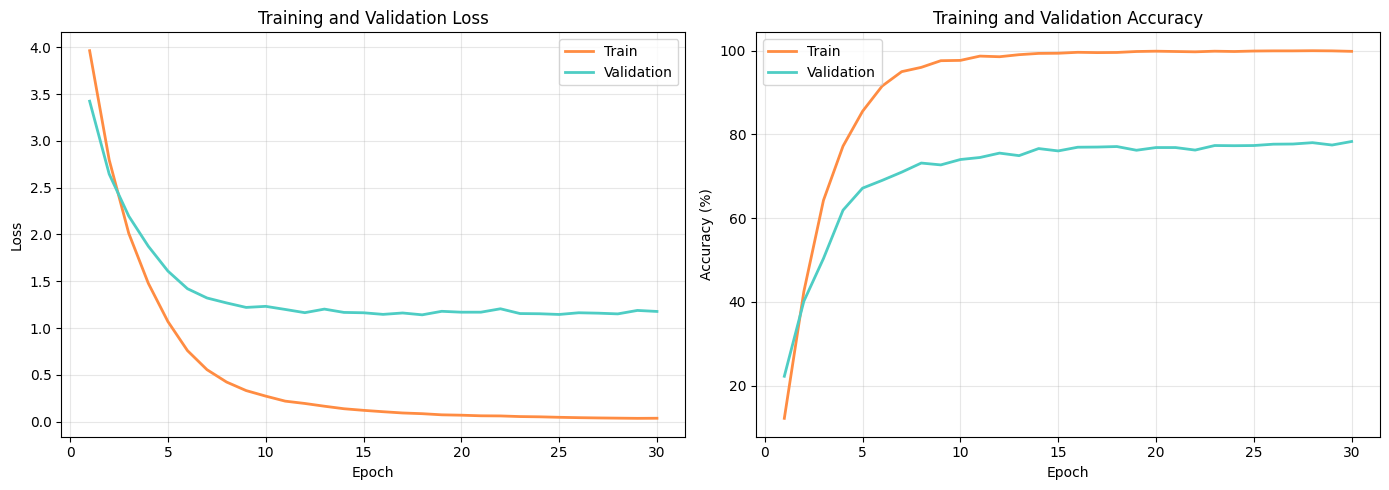


Training Summary
----------------------------------------
Final train loss: 0.0365
Final train acc:  99.85%
Final val loss:   1.1776
Final val acc:    78.31%
Overfitting gap:  21.54%
----------------------------------------


In [95]:
# 10.1 Plot training curves
def plot_training_curves(train_losses, train_accs, val_losses, val_accs):
    """Plot training history with softer colors."""
    epochs_range = range(1, len(train_losses) + 1)

    fig, axes = plt.subplots(1, 2, figsize=(14, 5))

    # Loss plot
    axes[0].plot(epochs_range, train_losses, color='#FF8C42', label='Train', linewidth=2)
    axes[0].plot(epochs_range, val_losses, color='#4ECDC4', label='Validation', linewidth=2)
    axes[0].set_xlabel('Epoch')
    axes[0].set_ylabel('Loss')
    axes[0].set_title('Training and Validation Loss')
    axes[0].legend()
    axes[0].grid(True, alpha=0.3)

    # Accuracy plot
    axes[1].plot(epochs_range, train_accs, color='#FF8C42', label='Train', linewidth=2)
    axes[1].plot(epochs_range, val_accs, color='#4ECDC4', label='Validation', linewidth=2)
    axes[1].set_xlabel('Epoch')
    axes[1].set_ylabel('Accuracy (%)')
    axes[1].set_title('Training and Validation Accuracy')
    axes[1].legend()
    axes[1].grid(True, alpha=0.3)

    plt.tight_layout()
    plt.savefig('training_curves.png', dpi=300, bbox_inches='tight')
    plt.show()

    print("\nTraining Summary")
    print("-" * 40)
    print(f"Final train loss: {train_losses[-1]:.4f}")
    print(f"Final train acc:  {train_accs[-1]:.2f}%")
    print(f"Final val loss:   {val_losses[-1]:.4f}")
    print(f"Final val acc:    {val_accs[-1]:.2f}%")
    print(f"Overfitting gap:  {train_accs[-1] - val_accs[-1]:.2f}%")
    print("-" * 40)

plot_training_curves(
    train_losses=train_losses,
    train_accs=train_accs,
    val_losses=val_losses,
    val_accs=val_accs
)

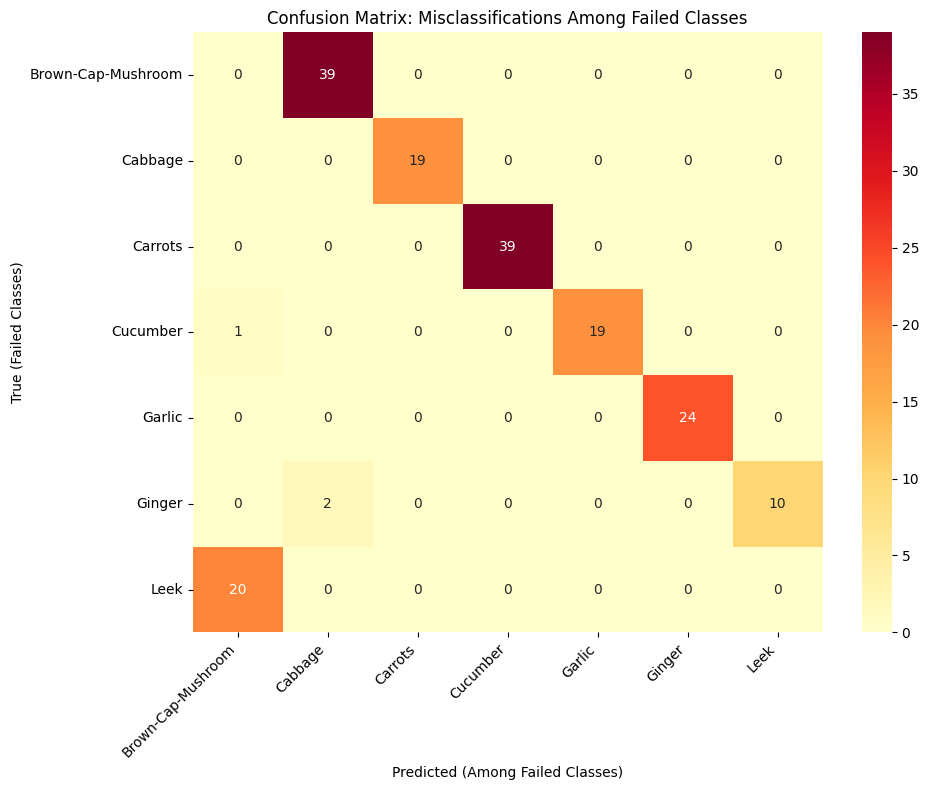


Confusion Matrix Statistics:
  Total test samples from failed classes: 188
  Misclassified within failed classes: 173 (92.0%)
  Misclassified to other classes: 15 (8.0%)


In [96]:
# 10.2 Get test predictions
model.load_state_dict(torch.load('best_resnet18_grocery.pth'))
model.to(device)
model.eval()

all_preds = []
all_labels = []

with torch.no_grad():
    for images, labels in test_loader:
        images = images.to(device)
        outputs = model(images)
        _, preds = outputs.max(1)
        all_preds.extend(preds.cpu().numpy())
        all_labels.extend(labels.numpy())

all_preds = np.array(all_preds)
all_labels = np.array(all_labels)

# 10.3 Confusion matrix - 7x7 showing only failed classes
def plot_failed_classes_confusion_matrix():
    zero_f1_indices = [class_names.index(cls) for cls in zero_f1_classes]

    # Filter to samples from failed classes only
    mask = np.isin(all_labels, zero_f1_indices)
    y_true = all_labels[mask]
    y_pred = all_preds[mask]

    # Map indices to 0-6 range
    idx_map = {old: new for new, old in enumerate(zero_f1_indices)}
    y_true_mapped = np.array([idx_map[i] for i in y_true])

    # Map predictions, use -1 for predictions outside failed classes
    y_pred_mapped = np.array([idx_map.get(i, -1) for i in y_pred])

    # Keep only predictions to other failed classes
    valid_mask = y_pred_mapped != -1
    y_true_final = y_true_mapped[valid_mask]
    y_pred_final = y_pred_mapped[valid_mask]

    # Create 7x7 confusion matrix
    cm = confusion_matrix(y_true_final, y_pred_final, labels=range(len(zero_f1_classes)))

    # Short names for display
    short_names = [cls.split('/')[-1] for cls in zero_f1_classes]

    # Plot
    plt.figure(figsize=(10, 8))
    sns.heatmap(cm, annot=True, fmt='d', cmap='YlOrRd',
                xticklabels=short_names,
                yticklabels=short_names)
    plt.xlabel('Predicted (Among Failed Classes)')
    plt.ylabel('True (Failed Classes)')
    plt.title('Confusion Matrix: Misclassifications Among Failed Classes')
    plt.xticks(rotation=45, ha='right')
    plt.yticks(rotation=0)
    plt.tight_layout()
    plt.savefig('failed_classes_cm_7x7.png', dpi=300, bbox_inches='tight')
    plt.show()

    # Summary statistics
    total_samples = len(y_true)
    within_failed = len(y_true_final)
    outside_failed = total_samples - within_failed

    print(f"\nConfusion Matrix Statistics:")
    print(f"  Total test samples from failed classes: {total_samples}")
    print(f"  Misclassified within failed classes: {within_failed} ({100*within_failed/total_samples:.1f}%)")
    print(f"  Misclassified to other classes: {outside_failed} ({100*outside_failed/total_samples:.1f}%)")

plot_failed_classes_confusion_matrix()

Misclassification Analysis:
------------------------------------------------------------

Brown-Cap-Mushroom (n=39):
  Cabbage                  :  39 (100.0%)

Cabbage (n=19):
  Carrots                  :  19 (100.0%)

Carrots (n=42):
  Cucumber                 :  39 ( 92.9%)
  Kaiser                   :   2 (  4.8%)
  Asparagus                :   1 (  2.4%)

Cucumber (n=27):
  Garlic                   :  19 ( 70.4%)
  Zucchini                 :   4 ( 14.8%)
  Brown-Cap-Mushroom       :   1 (  3.7%)

Garlic (n=25):
  Ginger                   :  24 ( 96.0%)
  Floury-Potato            :   1 (  4.0%)

Ginger (n=15):
  Leek                     :  10 ( 66.7%)
  Red-Beet                 :   3 ( 20.0%)
  Cabbage                  :   2 ( 13.3%)

Leek (n=21):
  Brown-Cap-Mushroom       :  20 ( 95.2%)
  Pineapple                :   1 (  4.8%)



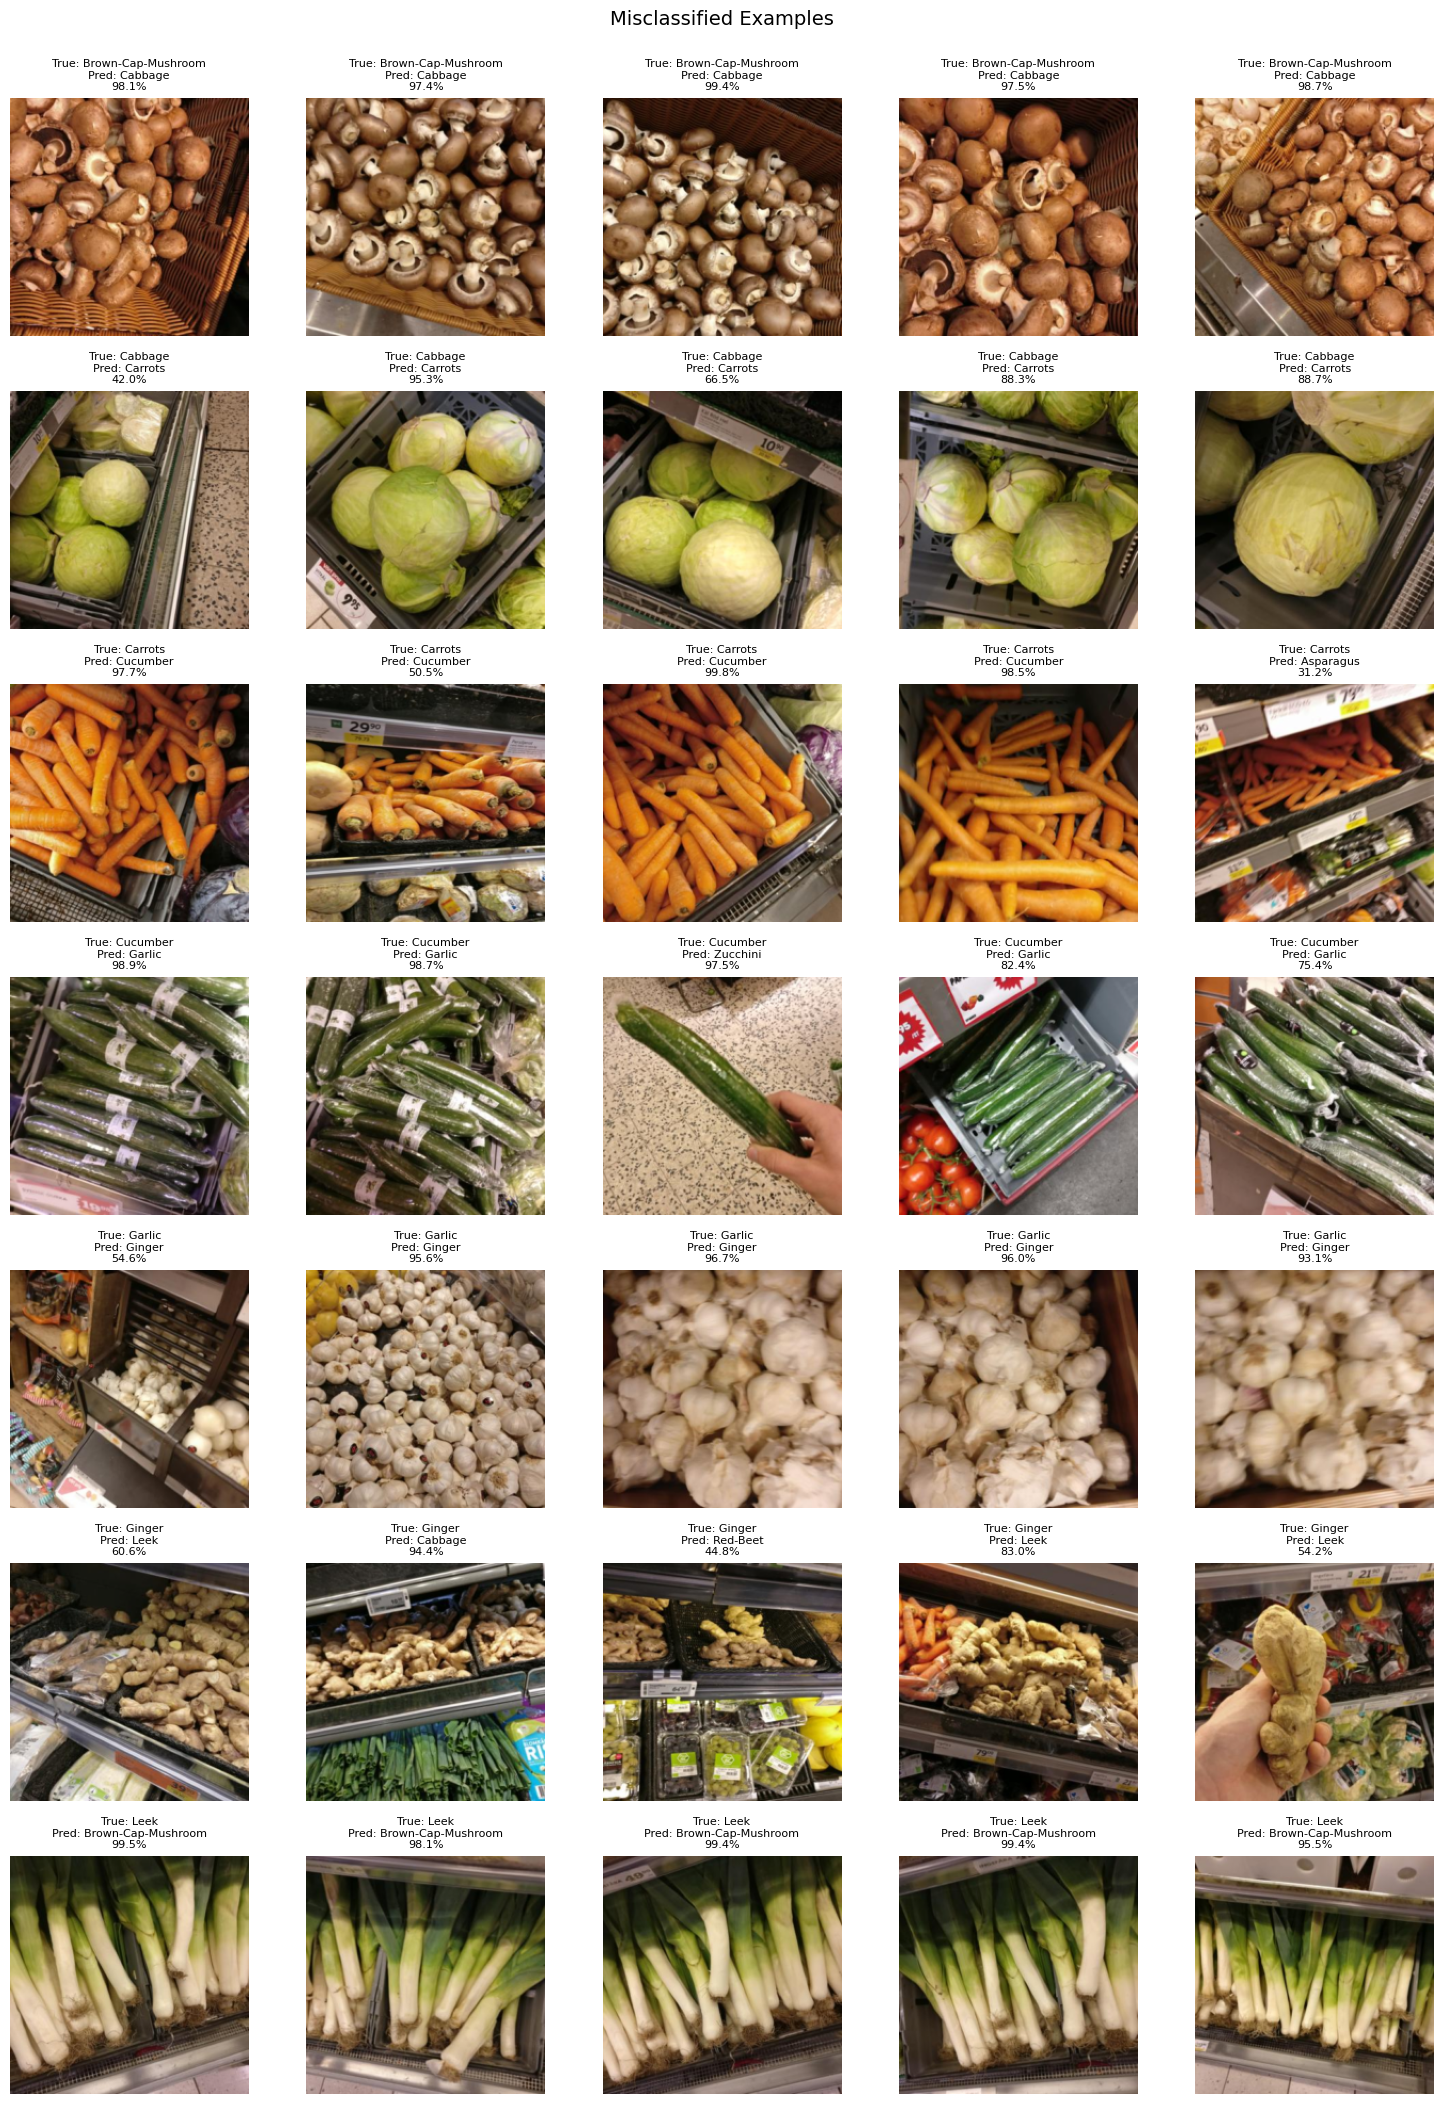


Visualization complete
Saved files:
  - training_curves.png
  - failed_classes_cm_7x7.png
  - misclassified_examples.png


In [92]:
# 10.4 Analyze misclassification patterns
def analyze_misclassifications():
    print("Misclassification Analysis:")
    print("-" * 60)

    for cls_name in zero_f1_classes:
        cls_idx = class_names.index(cls_name)
        mask = (all_labels == cls_idx)
        preds = all_preds[mask]

        cls_short = cls_name.split('/')[-1]

        if len(preds) > 0:
            pred_counts = Counter(preds)
            print(f"\n{cls_short} (n={len(preds)}):")
            for pred_idx, count in pred_counts.most_common(3):
                pct = 100 * count / len(preds)
                pred_short = class_names[pred_idx].split('/')[-1]
                print(f"  {pred_short:25s}: {count:3d} ({pct:5.1f}%)")

analyze_misclassifications()
print()

# 10.5 Visualize misclassified examples
def plot_misclassified_samples(num_samples=5):
    misclassified = {cls: [] for cls in zero_f1_classes}

    with torch.no_grad():
        for images, labels in test_loader:
            outputs = model(images.to(device))
            probs = torch.softmax(outputs, dim=1)
            _, preds = outputs.max(1)

            for i in range(len(labels)):
                true_idx = labels[i].item()
                pred_idx = preds[i].item()
                true_cls = class_names[true_idx]

                if true_cls in zero_f1_classes and true_idx != pred_idx:
                    if len(misclassified[true_cls]) < num_samples:
                        misclassified[true_cls].append({
                            'image': images[i],
                            'true': true_cls,
                            'pred': class_names[pred_idx],
                            'conf': probs[i, pred_idx].item()
                        })

    # Plot
    fig, axes = plt.subplots(len(zero_f1_classes), num_samples,
                            figsize=(15, 3 * len(zero_f1_classes)))

    if len(zero_f1_classes) == 1:
        axes = np.expand_dims(axes, axis=0)

    for i, cls in enumerate(zero_f1_classes):
        for j in range(num_samples):
            ax = axes[i, j]

            if j < len(misclassified[cls]):
                sample = misclassified[cls][j]

                # Denormalize
                img = sample['image'].permute(1, 2, 0).numpy()
                mean = np.array([0.485, 0.456, 0.406])
                std = np.array([0.229, 0.224, 0.225])
                img = std * img + mean
                img = np.clip(img, 0, 1)

                # Short names
                true_short = sample['true'].split('/')[-1]
                pred_short = sample['pred'].split('/')[-1]

                ax.imshow(img)
                ax.set_title(f"True: {true_short}\nPred: {pred_short}\n{sample['conf']:.1%}",
                           fontsize=8)
            else:
                ax.text(0.5, 0.5, 'No sample', ha='center', va='center')

            ax.axis('off')

    plt.suptitle('Misclassified Examples', fontsize=14, y=1.0)
    plt.tight_layout()
    plt.savefig('misclassified_examples.png', dpi=300, bbox_inches='tight')
    plt.show()

plot_misclassified_samples()

print("\nVisualization complete")
print("Saved files:")
print("  - training_curves.png")
print("  - failed_classes_cm_7x7.png")
print("  - misclassified_examples.png")

## 11. Model Saving & Loading

In [120]:
# Model information
model_path = 'best_resnet18_grocery.pth'
model_exists = os.path.exists(model_path)

print("Model Export Summary")
print("-" * 50)
print(f"Model architecture: ResNet-18")
print(f"Saved as: {model_path}")
print(f"File exists: {model_exists}")

if model_exists:
    model_size_mb = os.path.getsize(model_path) / (1024 * 1024)
    print(f"Model size: {model_size_mb:.2f} MB")

# Model parameters
total_params = sum(p.numel() for p in model.parameters())
trainable_params = sum(p.numel() for p in model.parameters() if p.requires_grad)

print(f"\nTotal parameters: {total_params:,}")
print(f"Trainable parameters: {trainable_params:,}")
print("-" * 50)

print("\nTo load the model:")
print("  model = models.resnet18()")
print("  model.fc = nn.Linear(model.fc.in_features, 81)")
print(f"  model.load_state_dict(torch.load('{model_path}'))")

Model Export Summary
--------------------------------------------------
Model architecture: ResNet-18
Saved as: best_resnet18_grocery.pth
File exists: True
Model size: 42.87 MB

Total parameters: 11,218,065
Trainable parameters: 11,218,065
--------------------------------------------------

To load the model:
  model = models.resnet18()
  model.fc = nn.Linear(model.fc.in_features, 81)
  model.load_state_dict(torch.load('best_resnet18_grocery.pth'))


In [ ]:
import json

# Save class names
class_names = test_dataset.classes  # List of 81 class names

with open('class_names.json', 'w') as f:
    json.dump(class_names, f, indent=2)

print(f"Saved {len(class_names)} class names to class_names.json")

In [9]:
# Display final results table
results_summary = {
    'Metric': [
        'Architecture',
        'Total Classes',
        'Macro F1 Score',
        'Train Accuracy',
        'Test Accuracy',
        'Overfitting Gap',
        'Classes with F1=1.0',
        'Classes with F1=0.0',
        'Training Epochs',
        'Best Epoch'
    ],
    'Value': [
        'ResNet-18',
        '81',
        '77.75%',
        '99.85%',
        '78.31%',
        '21.54%',
        '5',
        '7',
        '30',
        '30'
    ]
}

df_summary = pd.DataFrame(results_summary)
print("Final Model Performance Summary")
print("=" * 50)
print(df_summary.to_string(index=False))
print("=" * 50)

Final Model Performance Summary
             Metric     Value
       Architecture ResNet-18
      Total Classes        81
     Macro F1 Score    77.75%
     Train Accuracy    99.85%
      Test Accuracy    78.31%
    Overfitting Gap    21.54%
Classes with F1=1.0         5
Classes with F1=0.0         7
    Training Epochs        30
         Best Epoch        30


## 12. Summary & Next Steps

### Summary of Results
- Test Accuracy: 78.31%
- Macro F1: 77.75%
- Training showed overfitting

### Key Findings

**1. Circular Misclassification Pattern**
- 7 vegetable classes form a closed confusion loop
- 92% of failed class errors occur within this group
- Suggests visual similarity in color, shape, and store presentation

**2. Class Performance Distribution**
- Top performers: 5 classes with F1 score of 1.0
- Failed classes: 7 classes with F1 score of 0.0
- No failed fruit or packaged product classes

**3. Overfitting Analysis**
- Train: 99.85%, Val: 78.31% (21.5% gap)
- Model memorizes training data
- Needs regularization or data augmentation

### Limitations
- Small dataset size for 81 classes
- Class imbalance evident in distribution plots
- Similar vegetables hard to distinguish
- Store lighting/presentation variations

### Recommendations
1. Data augmentation for failed classes
2. Collect more varied images for vegetables
3. Try deeper architectures (ResNet-50)
4. Use hierarchical classification
5. Address class imbalance